In [1]:

import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from data_processing.data_validation import validate_json
from data_processing.create_features import create_features
from data_processing.pre_processing import pre_processing
from data_processing.post_processing import post_processing
from data_loading.azure_connector import load_data_from_datalake
from models.ml_model import make_prediction

import seaborn as sns
import pickle

In [2]:
data = pd.read_csv("data/creditcard.csv")
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

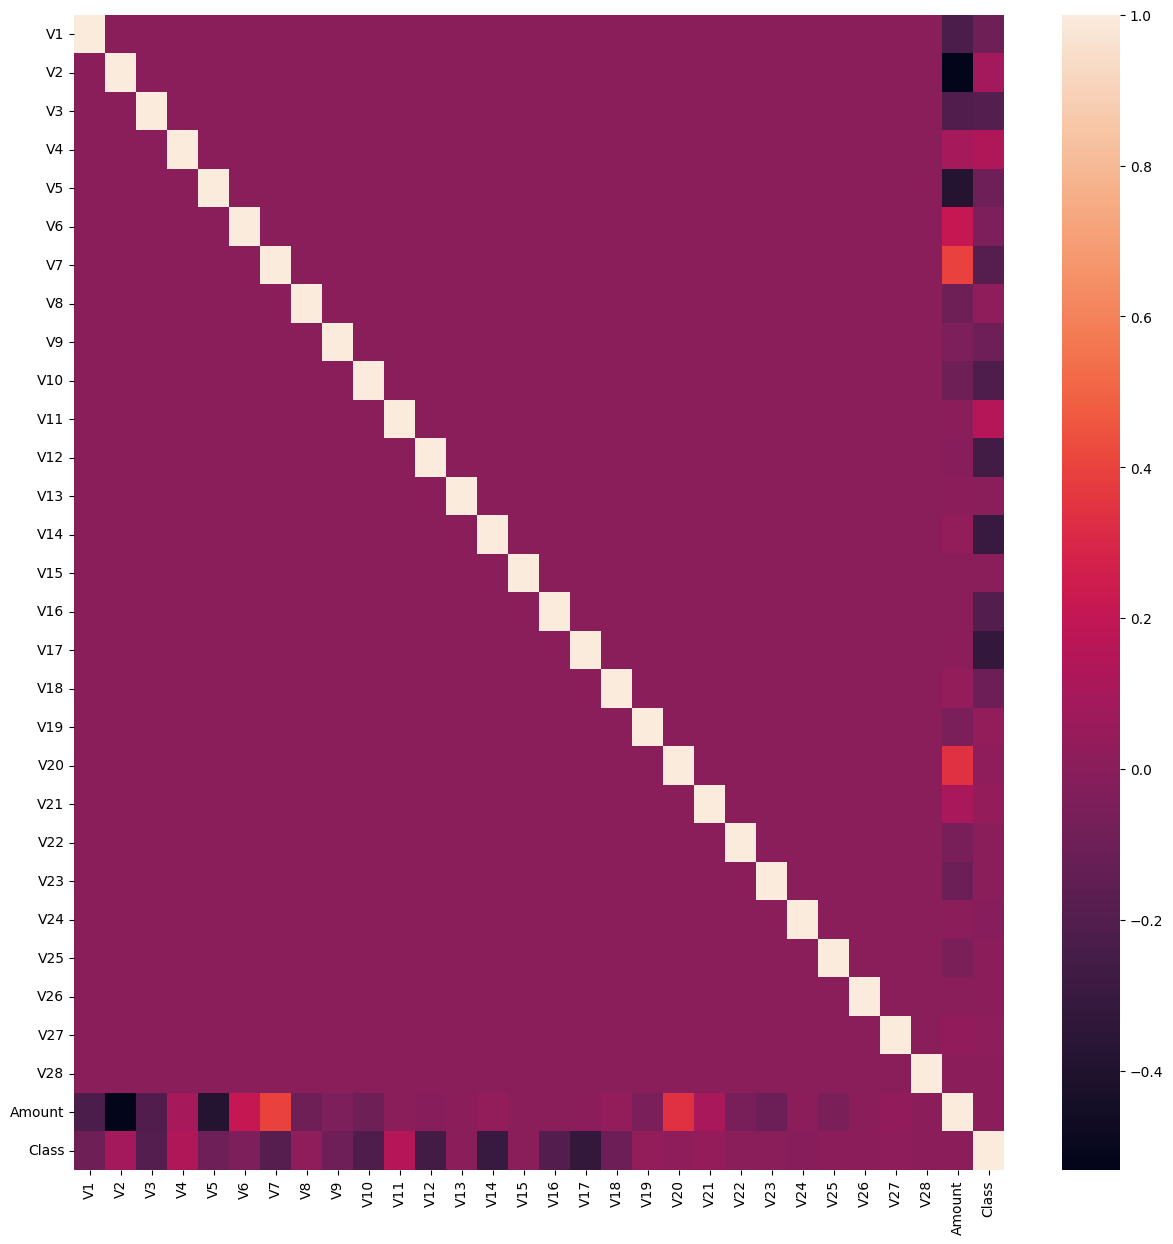

In [3]:
fig, ax = plt.subplots(1,1, figsize = (15, 15))
sns.heatmap(data[[c for c in data if c != "Time"]].corr(), ax = ax)

plt.show()

In [4]:
df_pre_computed = data.copy()
df_pre_computed["AmountLogMean"] = np.log(df_pre_computed["Amount"]).mean()
df_pre_computed = df_pre_computed[[c for c in df_pre_computed.columns if "AmountLogMean" == c]]
features = create_features(data.drop(["Class", "Time"], axis=1), df_pre_computed)
targets = data["Class"]

/opt/anaconda3/envs/my_tf_env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/my_tf_env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/opt/anaconda3/envs/my_tf_env/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010410 seconds.
You can set `force_col_wise=true` to remove the overhead.


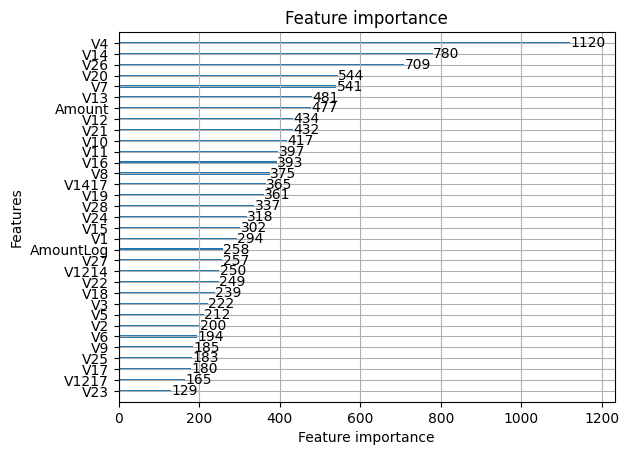

In [5]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=44)

# Convert the data into LightGBM's native format (Dataset object)
train_data = lgb.Dataset(X_train, label=y_train)

# Define the hyperparameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 25,
    'learning_rate': 0.005,
    'n_estimators': 500,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
model = lgb.train(params, train_data)

# Make predictions on the test set
y_pred = model.predict(X_test)

lgb.plot_importance(model)
plt.show()

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

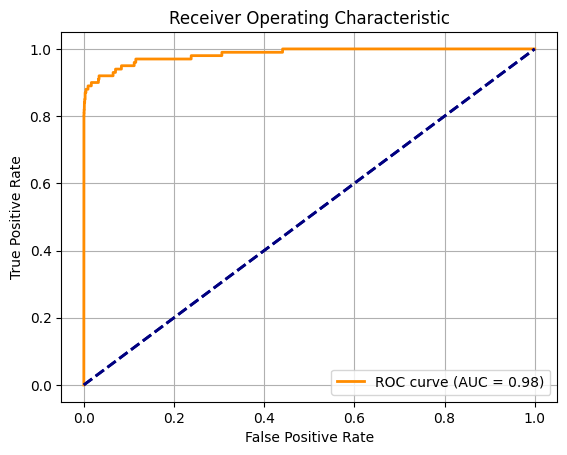

In [21]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot(((0,0), (1,1)), color='navy', lw=2, linestyle='--')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [7]:
print(classification_report(y_test, np.where(y_pred > 0.02, 1, 0)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.63      0.82      0.71       100

    accuracy                           1.00     56962
   macro avg       0.81      0.91      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [8]:
# store model in local project
with open("tmp/model_pre_features.pkl", "wb") as file:
    pickle.dump([model, df_pre_computed], file)

In [9]:
input_data = {
    "V1": [1],
    "V2": [1],
    "V3": [1],
    "V4": [1],
    "V5": [1],
    "V6": [1],
    "V7": [1],
    "V8": [1],
    "V9": [1],
    "V10": [1],
    "V11": [1],
    "V12": [1],
    "V13": [1],
    "V14": [1],
    "V15": [1],
    "V16": [1],
    "V17": [1],
    "V18": [1],
    "V19": [1],
    "V20": [1],
    "V21": [1],
    "V22": [1],
    "V23": [1],
    "V24": [1],
    "V25": [1],
    "V26": [1],
    "V27": [1],
    "V28": [1],
    "Time": [1],
    "Amount": [1]
}

In [12]:
make_prediction(input_data) # this function is also called in the API

[0.00027400258233021933]